# python-caffe



下面展示caffe的python接口如何，读取图片和展示以及在卷积神经网络中forward，及权重的可视化

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import caffe
caffe_root = '/root/caffe'
import os,sys

In [7]:
os.chdir(caffe_root)    # 将caffe的根目录作为当前目录
sys.path.insert(0,caffe_root+'python')


## 下面是caffe文件操作的代码

(360, 480, 3)


(-0.5, 479.5, 359.5, -0.5)

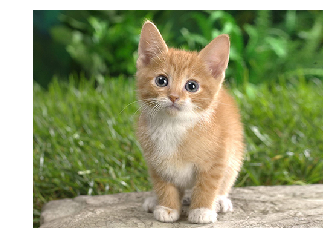

In [34]:
im = caffe.io.load_image('examples/images/cat.jpg')
print im.shape
plt.imshow(im);
plt.axis('off') # 关闭坐标尺

下面是加载网络模型和并使用初始化参数的方法,第二个参数不知道是什么意思

In [19]:
net = caffe.Net('examples/net_surgery/conv.prototxt',caffe.TEST)

将图像加载到网络的blob中,需要进行格式转换，维度xwidthxhight

In [35]:
im_input = im[np.newaxis,:,:,:].transpose(0,3,1,2) # 更改各个维度的顺序
print "data-blobs:",im_input.shape
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input

data-blobs: (1, 3, 360, 480)


而在python显示图像的时候需要转换成转换成widhtxhightxdims

(-0.5, 479.5, 359.5, -0.5)

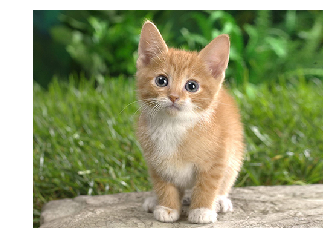

In [21]:
plt.imshow(net.blobs['data'].data[0].transpose(1,2,0))
plt.axis('off')

## 下面打show_data是一个工具函数，用来显示网络中的图像数据

In [22]:

plt.rcParams['image.cmap'] = 'gray'

def show_data(data,head,padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.title(head)
    plt.imshow(data)
    plt.axis('off')

从blob数据中将原始图像提取出来，并分别显示不同的通道图

data-blobs: (1, 3, 360, 480)


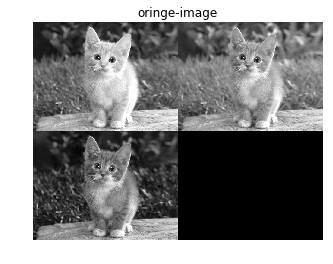

In [32]:
print 'data-blobs:',net.blobs['data'].data.shape
show_data(net.blobs['data'].data[0],'oringe-image')

## caffe 特征的可视化

调用forward()执行卷积操作，blobs数据发生改变。由原来的(1,3,360,480)变为（1，16，356，476）。

并初始化生成了相应的权值，权值数据为(16,3,5,5)。

最后调用两次show_data来分别显示权值和卷积过滤后的16通道图片。

data-blobs (1, 3, 360, 480)
conv-blobs (1, 16, 356, 476)
weight-blobs: (16, 3, 5, 5)


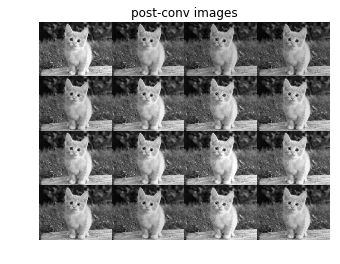

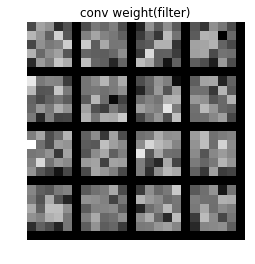

In [36]:
net.forward()
print 'data-blobs',net.blobs['data'].data.shape
print 'conv-blobs',net.blobs['conv'].data.shape  # 取top至为conv的那一层的输出
print "weight-blobs:",net.params['conv'][0].data.shape
show_data(net.blobs['conv'].data[0], 'post-conv images')
show_data(net.params['conv'][0].data[:,0], 'conv weight(filter)')

# python方式计算图像均值

图像减去均值后，再进行训练和测试，会提高速度和精度。c++方式直接用caffe编译后的工具就可以

```bash
sudo build/tools/compute_image_mean examples/mnist/mnist_train_lmdb examples/mnist/mean.binaryproto
```

python格式的均值计算，需要写一个python脚本来实现从.binaryproto文件转化乘.npy格式文件
```python
#!/usr/bin/env python
import numpy as np
import sys,caffe

if len(sys.argv)!=3:
    print "Usage: python convert_mean.py mean.binaryproto mean.npy"
    sys.exit()

blob = caffe.proto.caffe_pb2.BlobProto()
bin_mean = open( sys.argv[1] , 'rb' ).read()
blob.ParseFromString(bin_mean)
arr = np.array( caffe.io.blobproto_to_array(blob) )
npy_mean = arr[0]
np.save( sys.argv[2] , npy_mean )

```

将这个脚本保存为 convert_mean.py

调用方式为：

```
# sudo python convert_mean.py mean.binaryproto mean.npy
```

# 用python进行模型训练

[caffe的python接口学习（3）：训练模型（training)](http://www.cnblogs.com/denny402/p/5679204.html)


这里以cifar10的例子为例，首先到caffe的根目录去获取cifar10数据集进行数据格式转换和均值化操作，执行如下命令
```
./data/cifar10/get_cifar10.sh
./examples/cifar10/create_cifar10.sh
```

下面开始是python版模型训练的代码

In [42]:
import caffe,os,sys
caffe_root = '/root/caffe/'
os.chdir(caffe_root)
sys.path.insert(0,caffe_root+'python')
caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/cifar10/cifar10_full_solver.prototxt')
solver.solve()

# 训练好的caffe 的模型的可视化


下面引入必要的库

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,caffe
%matplotlib inline

下面设置caffe的目录

In [39]:
caffe_root = '/root/caffe/'
os.chdir(caffe_root)
sys.path.insert(0,caffe_root+'python')

下面设置网络的模型，加载网络模型和已经训练好的模型参数，显示该模型中各层名称和参数的规模

In [43]:
net = caffe.Net(caffe_root + 'examples/cifar10/cifar10_full.prototxt',
                caffe_root + 'examples/cifar10/cifar10_full_iter_60000.caffemodel.h5',
                caffe.TEST)
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (32, 3, 5, 5)),
 ('conv2', (32, 32, 5, 5)),
 ('conv3', (64, 32, 5, 5)),
 ('ip1', (10, 1024))]

cifar10训练的模型配置在文件cifar10_full.prototxt里面，共有三个卷积层和一个全连接层，参数模型如上所示。

下面是一个特征可视化的函数，与前文的show_data是一样的，首先设置绘图的参数信息

In [46]:
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#编写一个函数，用于显示各层的参数
def show_feature(data,title, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data)
    plt.title(title)
    plt.axis('off')

下面开始依次显示各层的参数

(32, 3, 5, 5)


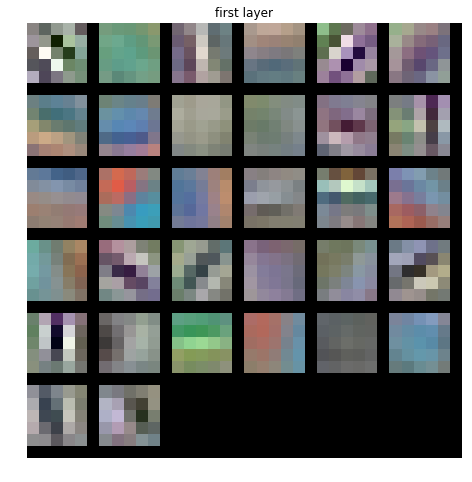

In [48]:
weight = net.params['conv1'][0].data
print weight.shape
show_feature(weight.transpose(0,2,3,1),'first layer')

(32, 32, 5, 5)


TypeError: Invalid dimensions for image data

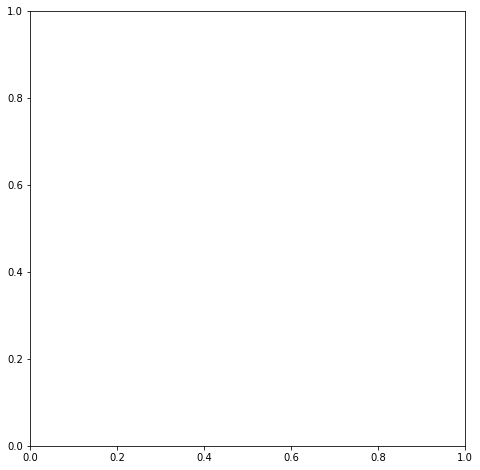

In [49]:
weight = net.params['conv2'][0].data
print weight.shape
show_feature(weight.transpose(0,2,3,1),'second layer')

上面的显示出错的原因是32通道不能以图像的形式显示，只能认为是32×32个filter，每个filter的尺寸是5*5,我们只显示前32个

(32, 32, 5, 5)


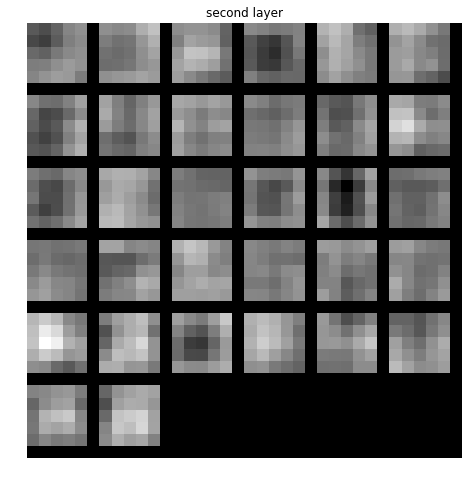

In [54]:
weight = net.params['conv2'][0].data
print weight.shape
show_feature(weight.reshape(32**2, 5, 5)[:32],'second layer')

第三层太多来，我们只显示前32个

(64, 32, 5, 5)


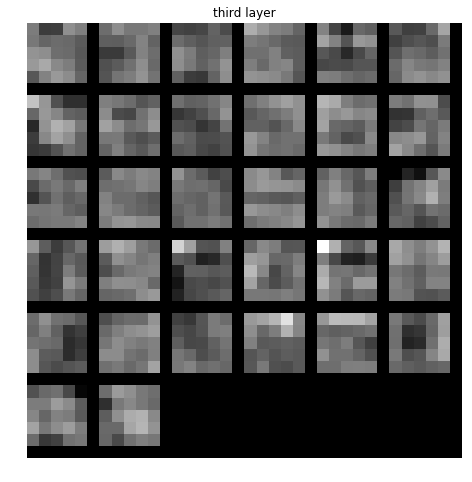

In [53]:
weight = net.params['conv3'][0].data
print weight.shape
show_feature(weight.reshape(32*64, 5, 5)[:32],'third layer')

# 用训练好的模型进行分类和可视化

In [26]:
#加载必要的库
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys,os,caffe
#设置当前目录，判断模型是否训练好
caffe_root = '/root/caffe/' 
sys.path.insert(0, caffe_root + 'python')
os.chdir(caffe_root)
if not os.path.isfile(caffe_root + 'examples/cifar10/cifar10_full_iter_60000.caffemodel.h5'):
    print("caffemodel is not exist...")

In [27]:
#利用提前训练好的模型，设置测试网络
caffe.set_mode_gpu()
net = caffe.Net(caffe_root + 'examples/cifar10/cifar10_full.prototxt',
                caffe_root + 'examples/cifar10/cifar10_full_iter_60000.caffemodel.h5',
                caffe.TEST)
net.blobs['data'].data.shape

(1, 3, 32, 32)

下面用一个例子图片来做测试

(360, 480, 3)


(-0.5, 479.5, 359.5, -0.5)

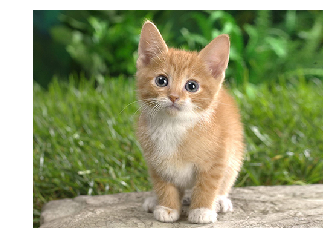

In [28]:

#加载测试图片，并显示
im = caffe.io.load_image('examples/images/cat.jpg')
print im.shape
plt.imshow(im)
plt.axis('off')

## 下面需要对图片进行维度转换并减去均值和降低分辨率等操作

首先需要获得训练数据的**python格式**均值

In [29]:
#　编写一个函数，将二进制的均值转换为python的均值
def convert_mean(binMean,npyMean):
    blob = caffe.proto.caffe_pb2.BlobProto()
    bin_mean = open(binMean, 'rb' ).read()
    blob.ParseFromString(bin_mean)
    arr = np.array( caffe.io.blobproto_to_array(blob) )
    npy_mean = arr[0]
    np.save(npyMean, npy_mean )
binMean=caffe_root+'examples/cifar10/mean.binaryproto'
npyMean=caffe_root+'examples/cifar10/mean.npy'
convert_mean(binMean,npyMean)

下面是对测试图像用io.transformer进行转换的一系列预处理操作

In [30]:

#将图片载入blob中,并减去均值
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(npyMean).mean(1).mean(1)) # 减去均值
transformer.set_raw_scale('data', 255)  
transformer.set_channel_swap('data', (2,1,0))
net.blobs['data'].data[...] = transformer.preprocess('data',im)
inputData=net.blobs['data'].data

(-0.5, 31.5, 31.5, -0.5)

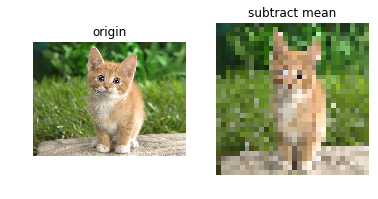

In [25]:
#显示减去均值前后的数据
plt.figure()
plt.subplot(1,2,1),plt.title("origin")
plt.imshow(im)
plt.axis('off')
plt.subplot(1,2,2),plt.title("subtract mean")
plt.imshow(transformer.deprocess('data', inputData[0]))  # 这里deprocess是preprocess的逆过程
plt.axis('off')

## 运行测试模型并可视化

下面是各层数据信息

In [33]:
net.forward()
[(k,v.data.shape) for k,v in net.blobs.items()]

[('data', (1, 3, 32, 32)),
 ('conv1', (1, 32, 32, 32)),
 ('pool1', (1, 32, 16, 16)),
 ('norm1', (1, 32, 16, 16)),
 ('conv2', (1, 32, 16, 16)),
 ('pool2', (1, 32, 8, 8)),
 ('norm2', (1, 32, 8, 8)),
 ('conv3', (1, 64, 8, 8)),
 ('pool3', (1, 64, 4, 4)),
 ('ip1', (1, 10)),
 ('prob', (1, 10))]

In [34]:
# 下面是各层的参数信息

[(k, v[0].data.shape) for k,v in net.params.items()]

[('conv1', (32, 3, 5, 5)),
 ('conv2', (32, 32, 5, 5)),
 ('conv3', (64, 32, 5, 5)),
 ('ip1', (10, 1024))]

下面依然用之前写的显示函数进行显示

In [37]:
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#编写一个函数，用于显示各层的参数
def show_feature(data,title, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data)
    plt.title(title)
    plt.axis('off')

首先显示第一层卷积层的输出数据,这是32个32×32的图像，而这个show_feature能够将每个通道都显示出来

(32, 32, 32)


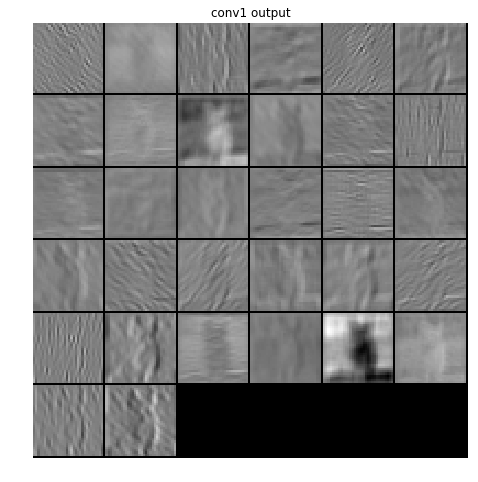

In [38]:
show_feature(net.blobs['conv1'].data[0],'conv1 output')
print net.blobs['conv1'].data[0].shape

下面显示第一层的参数信息

(32, 3, 5, 5)


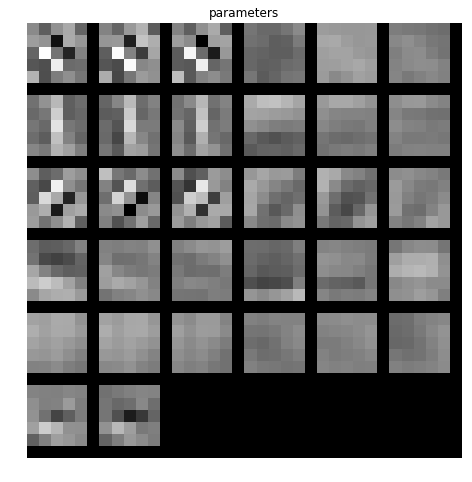

In [41]:
show_feature(net.params['conv1'][0].data.reshape(32*3,5,5)[:32], 'parameters' )
print net.params['conv1'][0].data.shape

而最后一层的输出表示的是属于某一类的概率


[ 0.00520415  0.00116352  0.30740851  0.30073324  0.23969874  0.04378513
  0.08947577  0.00894053  0.00143278  0.00215758]


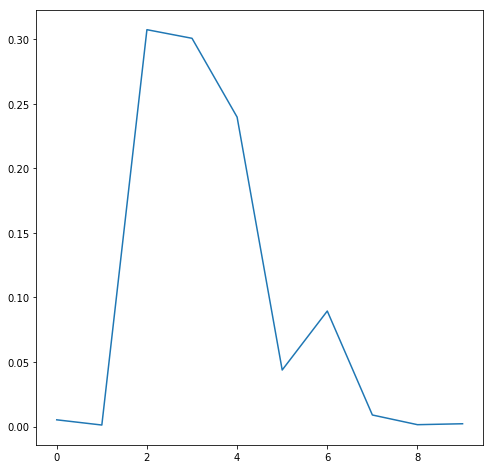

In [43]:
feat = net.blobs['prob'].data[0]
print feat
plt.plot(feat.flat)

# 模型可视化

[caffe学习系列：绘制网络模型](http://www.cnblogs.com/denny402/p/5106764.html)

需要两个库:用apt-get安装的**Graphviz**，和用pipanzhaung的pydot

然后使用python文件夹下面的draw_net.py来进行网络的绘制

draw_net.py执行的时候带三个参数

第一个参数：网络模型的prototxt文件

第二个参数：保存的图片路径及名字

第二个参数：--rankdir=x , x 有四种选项，分别是LR, RL, TB, BT 。用来表示网络的方向，分别是从左到右，从右到左，从上到小，从下到上。默认为ＬＲ。

例：绘制Lenet模型

```bash
sudo python python/draw_net.py examples/mnist/lenet_train_test.prototxt netImage/lenet.png --rankdir=BT

```

![](http://images2015.cnblogs.com/blog/140867/201601/140867-20160106200045965-1214280199.png)

# 绘制accuracy和loss曲线



In [45]:
#加载必要的库
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys,os,caffe
#设置当前目录
caffe_root = '/root/caffe/' 
sys.path.insert(0, caffe_root + 'python')
os.chdir(caffe_root)

In [46]:
# set the solver prototxt
caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/cifar10/cifar10_quick_solver.prototxt')

下面还计算时间

如果不需要绘制曲线，只需要训练出一个caffemodel, 直接调用**solver.solve()**就可以了。

如果要绘制曲线，就需要把迭代过程中的值保存下来，因此不能直接调用solver.solve(), 需要迭代。在迭代过程中，每迭代200次测试一次

In [47]:
%%time
niter =4000
test_interval = 200
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    solver.test_nets[0].forward(start='conv1')
    
    if it % test_interval == 0:
        acc=solver.test_nets[0].blobs['accuracy'].data
        print 'Iteration', it, 'testing...','accuracy:',acc
        test_acc[it // test_interval] = acc

Iteration 0 testing... accuracy: 0.0900000035763
Iteration 200 testing... accuracy: 0.370000004768
Iteration 400 testing... accuracy: 0.509999990463
Iteration 600 testing... accuracy: 0.490000009537
Iteration 800 testing... accuracy: 0.560000002384
Iteration 1000 testing... accuracy: 0.579999983311
Iteration 1200 testing... accuracy: 0.600000023842
Iteration 1400 testing... accuracy: 0.629999995232
Iteration 1600 testing... accuracy: 0.670000016689
Iteration 1800 testing... accuracy: 0.670000016689
Iteration 2000 testing... accuracy: 0.670000016689
Iteration 2200 testing... accuracy: 0.639999985695
Iteration 2400 testing... accuracy: 0.649999976158
Iteration 2600 testing... accuracy: 0.709999978542
Iteration 2800 testing... accuracy: 0.699999988079
Iteration 3000 testing... accuracy: 0.769999980927
Iteration 3200 testing... accuracy: 0.709999978542
Iteration 3400 testing... accuracy: 0.689999997616
Iteration 3600 testing... accuracy: 0.72000002861
Iteration 3800 testing... accuracy: 0.

[ 0.09        0.37        0.50999999  0.49000001  0.56        0.57999998
  0.60000002  0.63        0.67000002  0.67000002  0.67000002  0.63999999
  0.64999998  0.70999998  0.69999999  0.76999998  0.70999998  0.69
  0.72000003  0.68000001]


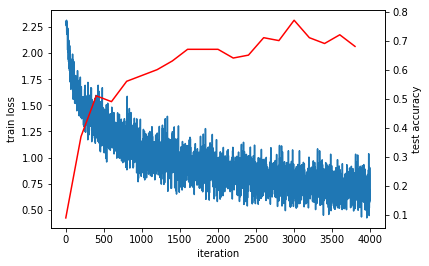

In [48]:
print test_acc
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')

从上图可以看出accuracy曲线还略有下降,而从loss曲线来看还是很震荡的

# 使用别人训练好的库来做分类 

caffe的一个优势在于，官方提供来很多已经训练好的caffe_model,我们能够直接使用这些model来做训练。这些model管理在[modle-zoo里。](https://github.com/BVLC/caffe/wiki/Model-zoo)，可以在[这里](http://dl.caffe.berkeleyvision.org/)进行下载。

使用别人训练好的分类器的时候，需要三个文件：

1. 训练好的model文件
2. 训练model的时候用的训练数据的均值文件
3. 使用的分类名列表

下面的例子使用的是bvlc提供的caffe_model使用Imagenet训练的(ilsvrc2012竞赛数据)

下面获取imagenet的均值文件和分类名文件，放在data/ilsvrc12文件夹里面
```bash
 sudo ./scripts/download_model_binary.py models/bvlc_reference_caffenet

```


In [52]:
#加载必要的库
import numpy as np

import sys,os

#设置当前目录
caffe_root = '/root/caffe/' 
sys.path.insert(0, caffe_root + 'python')
import caffe
os.chdir(caffe_root)

net_file=caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
caffe_model=caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
mean_file=caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy'

net = caffe.Net(net_file,caffe_model,caffe.TEST)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(mean_file).mean(1).mean(1))
transformer.set_raw_scale('data', 255) 
transformer.set_channel_swap('data', (2,1,0))

im=caffe.io.load_image(caffe_root+'examples/images/cat.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data',im)
out = net.forward()


imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

top_k  = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
for i in np.arange(top_k.size):
    print net.blobs['prob'].data[0][top_k[i]], labels[top_k[i]]

0.312446 n02123045 tabby, tabby cat
0.23797 n02123159 tiger cat
0.123878 n02124075 Egyptian cat
0.100752 n02119022 red fox, Vulpes vulpes
0.0709573 n02127052 lynx, catamount
